## In this TD, we study the wavelet decomposition using the Daubechies 4 filters.
### Hereafter, we compute a multiscale decomposition in the spirit of wavelets using Fourier.
We are looking for a linear operator 
\begin{align}
W: \,&\mathbb{C}^N \to \mathbb{C}^{N_1} \times \ldots \times \mathbb{C}^{N_2}\\
&u_0 \mapsto (u_0,\ldots,u_n)\,,
\end{align}
which is an isometry which means:

\begin{equation}
\forall u \in \mathbb{C}^{N_0}, \| u \|_2 = \| Wu\|_2
\end{equation}


In [1]:
from __future__ import division
#from scipy.misc import imsave
import numpy as np
import scipy as sp
import scipy.fftpack as ft
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


103.84888513565065 82.66806868885021 0.0
(1024, 1024)


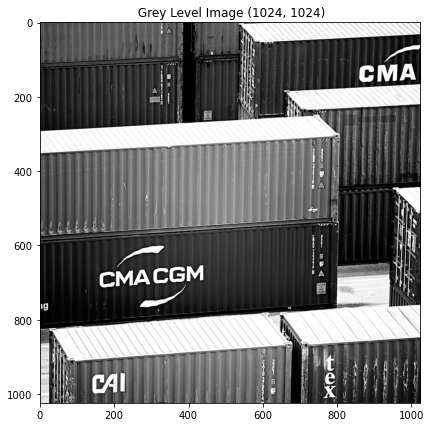

In [2]:
# load an image
import imageio as imio
colored_image = imio.imread('01.jpg')
n = 500
image = np.sum(colored_image*[0.21, 0.72 ,0.07],axis=-1)
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.gray()
cropped = image[n:n+64,n:n + 64]
cropped = image
plt.title(" Grey Level Image " + str(np.shape(cropped)))

plt.imshow(cropped)
print(np.mean(cropped),np.std(cropped),(np.min(cropped)))
print(image.shape)
image0 = np.copy(image)

## What are the conditions on the filters for being admissible wavelet filters: The first condition on the low-pass filter $h$ is \begin{equation} \begin{cases}|\hat{h}(\omega)|^2 + |\hat{h}(\omega + \frac 12)|^2 = 2\\\hat{h}(0) = \sqrt{2}\,.\end{cases}\end{equation}
## The condition on the high-pass filter is the following:  \begin{equation} \begin{cases}|\hat{g}(\omega)|^2 + |\hat{g}(\omega + \frac 12)|^2 = 2\\\hat{g}(\omega) \hat{h}^*(\omega)+ \hat{g}(\omega + \frac 12)\hat{h}^*(\omega + \frac 12) = 0\,.\end{cases}\end{equation}
### It is possible to find this condition by writing the orthogonality condition of the scaling function and the wavelet function at scale 0 and scale 1. It is similar to the computation presented in the previous lecture.

## Below are given the 4-Daubechies filters: the filter h corresponds to the low pass filter and the filter g corresponds to the high-pass filter. This filter is designed so that the first two moments of the wavelet function vanish. Thus, it encodes more efficiently parts of the image which have a behaviour close to a polynomial function of degree 2.

In [3]:
h = [0, .482962913145, .836516303738, .224143868042, -.129409522551]
h = h/norm(h) ## make sure the filter has norm 1.
u = power(-ones(len(h)-1),range(1,len(h))) # alternate +1/-1
g = concatenate(([0], h[-1:0:-1] * u))
print("low-pass filter associated with the scaling function",h)
print("high-pass filter associated with the wavelet function",g)

low-pass filter associated with the scaling function [ 0.          0.48296291  0.8365163   0.22414387 -0.12940952]
high-pass filter associated with the wavelet function [ 0.          0.12940952  0.22414387 -0.8365163   0.48296291]


### We choose below periodic boundary condition for the filtering which is the simplest condition one can use. More involved treatment of the boundaries have been developed.

In [4]:
# Below is a circular convolution implemented
def cconv(x, h, d):
    if d == 1:
        return np.transpose(cconv(np.transpose(x), h, 0))
    y = np.zeros(x.shape)
    p = len(h)
    pc = int(round( float((p - 1) / 2 )))
    for i in range(0, p):
        y = y + h[i] * np.roll(x, pc-i, axis=0)
    return y

### Q1: Test that the subsampling and upsampling operators defined below ared adjoint operators. That is, you test on random vectors that the following equality holds: $\langle \text{subsampling}(x),y \rangle = \langle \text{upSampling}(y),x \rangle$.

In [5]:
def subsampling(x, d):
    p = 2
    if d == 0:
        y = x[::p, :]
    elif d == 1:
        y = x[:, ::p]
    return y

def upsampling(x, d):
    p = 2
    s = x.shape
    if d == 0:
        y = np.zeros((p * s[0], s[1]))
        y[::p, :] = x
    elif d == 1:
        y = np.zeros((s[0], p * s[1]))
        y[:, ::p] = x
    return y

def reverse(x):
    return x[::-1]

In [6]:
x = np.random.rand(512, 512)
y = np.random.rand(256, 512)

subX = subsampling(x, 0)
upY = upsampling(y, 0)

print(np.vdot(subX,y) - np.vdot(upY, x) <= 1e-1)

True


### In order to extend the wavelet transform in 2D on images, simply perform the wavelet transform iteratively on the dimension of the image. 
First choose for instance, the lines of the image and perform wavelet transform thus obtaining $low scale(0)$ and $high scale(0)$ on the lines (0 is the index for the lines and 1 for the columns). Then, you apply again the wavelet transform in the other direction, let's say the columns, for each part of the transformed signal. Thus, you obtain: $high scale(1)(low scale(0))$ and $high scale(1)(high scale(0))$ and  $low scale(1)(high scale(0))$ and $low scale(1)(low scale(0))$. You thus have four parts for the 1 step wavelet transform for a given image. It is usually concatenated in an array of this type: $\begin{pmatrix} LL & HL \\ LH & HH\end{pmatrix}$ where $L$ and $H$ represent respectively low and high scale.

## Q2: Implement below the one step of W transform of the lecture. Coarse and Fine scale transforms and test it on your image.

In [66]:
def coarse(x, d):
    # d is the dimension along which the operation is performed.
    # the formula to be implemented is the convolution of x by h along the dimension d.
    coarse = cconv(x, h, d)
    return subsampling(coarse, d)

def fine(x,d):
    # d is the dimension along which the operation is performed.
    # the formula to be implemented is the convolution of x by g along the dimension d.
    fine = cconv(x, g, d)
    return subsampling(fine, d)

def W_0(image):
    L = coarse(image, 1)
    H = fine(image, 1)
    image = np.concatenate((L, H), axis=0)

    L = coarse(image, 0)
    H = fine(image, 0)
    image = np.concatenate((L, H), axis=1)

    return image

def W_0Bis(image):
    L = coarse(image, 0)
    H = fine(image, 0)

    LL = coarse(L, 1)
    LH = fine(L, 1)
    HL = coarse(H, 1)
    HH = fine(H, 1)

    return np.concatenate((np.concatenate((LL, LH), axis=1), np.concatenate((HL, HH), axis=1)), axis=0)

0.0


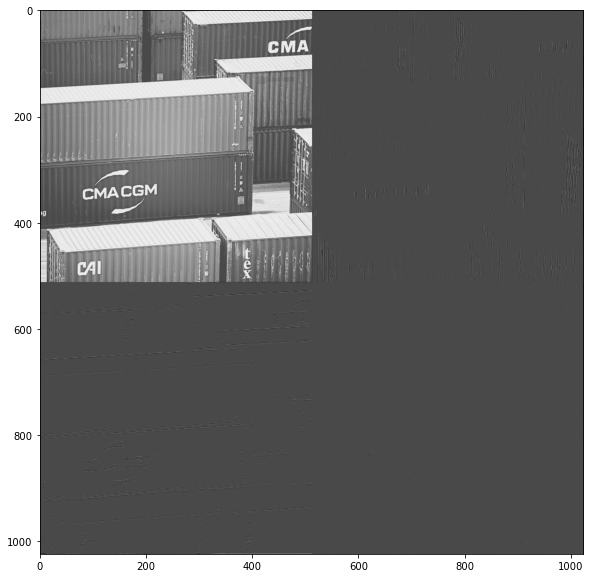

In [64]:
print((W_0Bis(image) - W_0Bis(image)).sum())
plt.figure(figsize = (10,10))
plt.imshow(W_0(image))

## Q3: Implement the full fast wavelet transform for a given number of scales.

In [53]:
def WaveletTransform(image, iterations=2):
    wavelet = image.copy()
    sub = wavelet
    for i in range(iterations):
        sub[:] = W_0(sub)
        sub = sub[:int(sub.shape[0]//2), :int(sub.shape[1]//2)]
    return wavelet

Lossy conversion from float64 to uint8. Range [-231.67954183959353, 571.398459253629]. Convert image to uint8 prior to saving to suppress this warning.


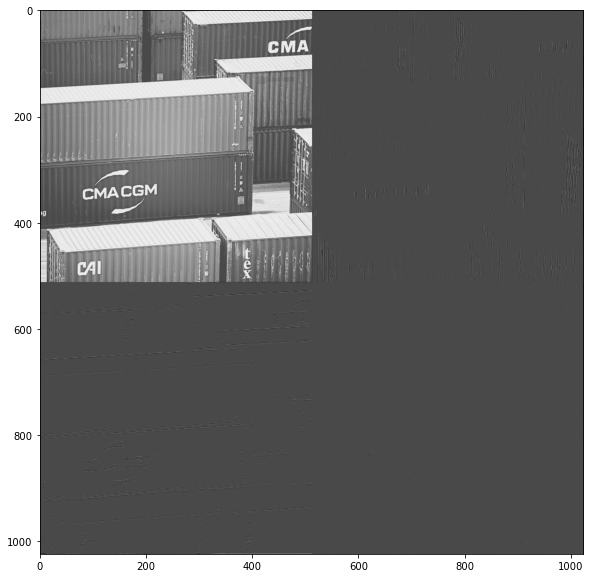

In [54]:
iterations = 1
wavelet = WaveletTransform(image, iterations)
plt.figure(figsize = (10,10))
plt.imshow(wavelet)
imio.imsave(f'test{iterations}.jpg', wavelet)

## Q4: Below are functions to obtain a better plot of the results. Using the functions below, plot the wavelet transform.

In [55]:
def rescale(f,a=0,b=1):
    ## function that rescale f between a and b.
    rang = f.max() - f.min()
    g = (f - f.min()).copy()
    if rang > 0:
        g = g / rang
    return a + g*(b-a)

def rescaleWav(A):
    ## function dedicated to a proper rescale of wavelet representation (particular case of the previous one).
    sup = abs(A).max()
    B = A.copy()
    if sup > 0:
        B = .5 + .5 * A / sup
    return B
    
def PlotWavelet(wavelet, iterations=1):
    ## Plot the wavelet representation, need to specify the number of iterations (or scales at which the FWT is computed).
    n = wavelet.shape[1]
    Jmax = int(np.log2(n)) - 1
    Jmin = Jmax - iterations + 1
    
    U = wavelet.copy()
    for j in np.arange(Jmax, Jmin - 1, -1):
        U[:2 ** j:,    2 ** j:2 **
            (j + 1):] = rescaleWav(U[:2 ** j:, 2 ** j:2 ** (j + 1):])
        U[2 ** j:2 ** (j + 1):, :2 **
          j:] = rescaleWav(U[2 ** j:2 ** (j + 1):, :2 ** j:])
        U[2 ** j:2 ** (j + 1):, 2 ** j:2 ** (j + 1):] = (
            rescaleWav(U[2 ** j:2 ** (j + 1):, 2 ** j:2 ** (j + 1):]))
    # coarse scale
    U[:2 ** j:, :2 ** j:] = rescale(U[:2 ** j:, :2 ** j:])
    # plot underlying image
    plt.imshow(U)
    # display crosses
    for j in np.arange(Jmax, Jmin - 1, -1):
        plt.plot([0, 2 ** (j + 1)], [2 ** j, 2 ** j], 'b')
        plt.plot([2 ** j, 2 ** j], [0, 2 ** (j + 1)], 'b')
    return U

array([[0.53726084, 0.50403552, 0.52078822, ..., 0.54573938, 0.47188779,
        0.43460113],
       [0.52347656, 0.35150125, 0.36826669, ..., 0.51112399, 0.55397834,
        0.18304407],
       [0.42463817, 0.35366564, 0.35489856, ..., 0.4896017 , 0.47475052,
        0.31861879],
       ...,
       [0.50419581, 0.46323451, 0.48022062, ..., 0.50501885, 0.49405418,
        0.51841497],
       [0.52098158, 0.48673392, 0.52700822, ..., 0.49865089, 0.5002271 ,
        0.51414274],
       [0.44929475, 0.21833329, 0.25868221, ..., 0.49033768, 0.50416673,
        0.03013442]])

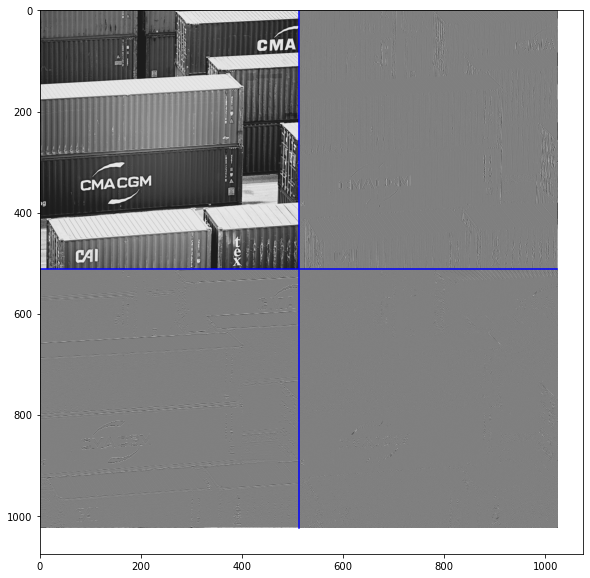

In [56]:
plt.figure(figsize = (10,10))
PlotWavelet(wavelet, iterations)

## Q5: The wavelet transform is an orthogonal transformation so its inverse is given by its transpose (also called adjoint). Use the two operators defined below to implement the inverse of the wavelet transform.

In [57]:
def AdjointCoarse(image,d):
    adjoint_h = reverse(h)
    return cconv(upsampling(image,d),adjoint_h,d)
def AdjointFine(image,d):
    adjoint_g = reverse(g)
    return cconv(upsampling(image,d),adjoint_g,d)

In [83]:
# Hereafter, you just implement the inverse of a one-step wavelet transform.
def IW_0(wavelet):

    n = np.array(wavelet.shape[:2])//2

    LL = AdjointCoarse(wavelet[:n[0], :n[1]], 1)
    LH = AdjointFine(wavelet[n[0]:, :n[1]], 1)
    HL = AdjointCoarse(wavelet[:n[0], n[1]:], 1)
    HH = AdjointFine(wavelet[n[0]:, n[1]:], 1)

    return AdjointCoarse(LL+LH, 0) + AdjointFine(HL+HH, 0)


def IWT(wavelet, iterations = 3):
    image = wavelet.copy()
    subShapes = np.tile(image.shape[:2],(iterations, 1)).T//2**np.arange(iterations)[::-1]
    for i in range(iterations):
        image[:subShapes[0, i], :subShapes[1, i]] = IW_0(image[:subShapes[0, i], :subShapes[1, i]])
    return image

   ## Q6: Test on an image that the implemented inverse is correct. That is, check on an image $x$ that $IWT(WaveletTransform(x)) = x$ up to numerical errors.

diff between original and recovered: 9008327.167557504


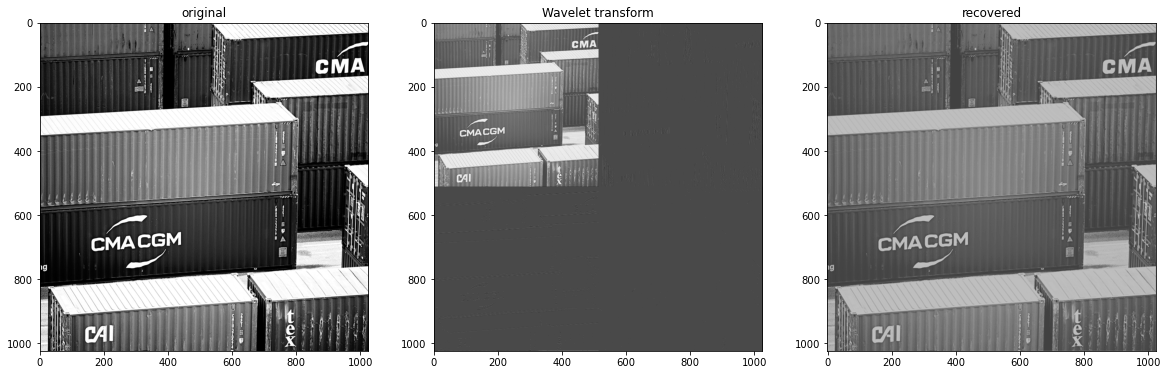

In [86]:
# recovered = IWT(wavelet, iterations)
recovered = IWT(wavelet, iterations)
plt.figure(figsize = (20,20))
plt.subplot(131)
plt.title("original")
plt.imshow(image)
plt.subplot(132)
plt.title("Wavelet transform")
plt.imshow(wavelet)
plt.subplot(133)
plt.title("recovered")
plt.imshow(recovered)

print('diff between original and recovered:', np.abs(image-recovered).sum())

# Use of wavelets for compression.

## Q7: Plot the histogram of the wavelet coefficients just to see the repartition between small and large coefficients by modifying the code below. You should see that most of the coefficients are close to $0$ and few are large coefficients. Thus, the idea is that lossy compression might perform well on this data.

1048576
-130.25958224789022


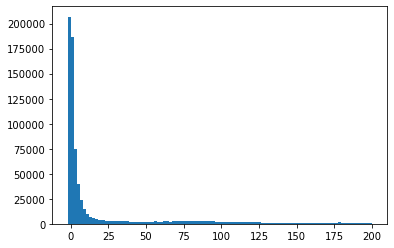

In [77]:
import pylab as pl
temp = wavelet.flatten()
pl.hist(temp,bins = linspace(-2,200,100))
temp.sort()
print(len(temp))
print(temp[500])

## Q8: Consider the 20% largest coefficients of the wavelet transform and put all the remaining coefficients to $0$ and show the resulting approximating image. Do the same with Fourier transform by calling the $fft2$ function and compare visually and compare using the function implemented below which is the signal to noise ratio function.

In [87]:
def snr(x, y):
    s =  np.linalg.norm(x - y)
    if s == 0:
        return "Equal inputs"
    return 20 * np.log10(np.linalg.norm(x) /s)

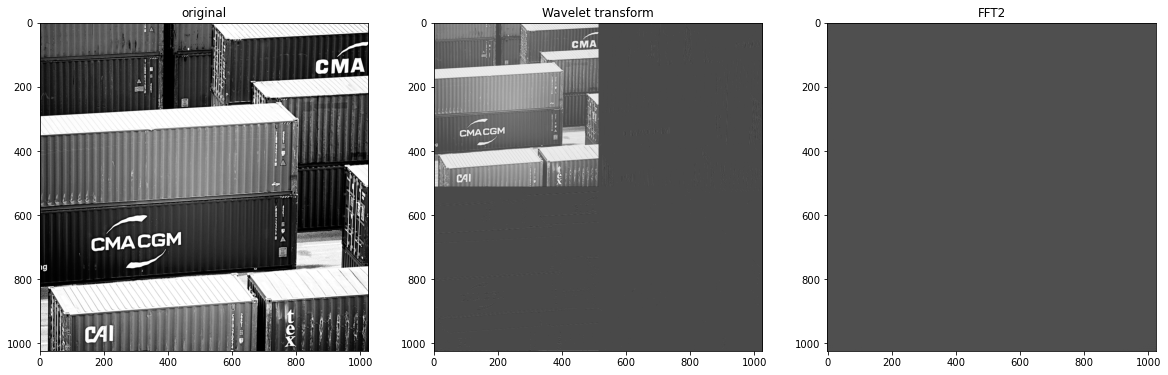

In [89]:
import scipy.fftpack as sf

iwv = real(sf.fft2(wavelet))

plt.figure(figsize = (20,20))
plt.subplot(131)
plt.title("original")
plt.imshow(image)
plt.subplot(132)
plt.title("Wavelet transform")
plt.imshow(wavelet)
plt.subplot(133)
plt.title("FFT2")
plt.imshow(iwv)

## Last note that one can look at the wavelet function by plotting the image of a Dirac mass. Run and play with the code below.

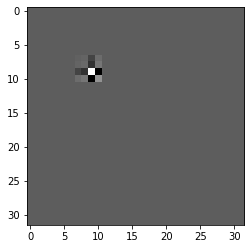

In [90]:
n = 32
dirac = np.zeros((n,n))
dirac[20,20] = 1
ondelette = IW_0(dirac)
plt.imshow(ondelette)